## Copyright 2022 Google LLC. Double-click for license information.

In [1]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Null-text inversion + Editing with Prompt-to-Prompt

In [2]:
from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm.notebook import tqdm
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch.nn.functional as nnf
import numpy as np
import abc
import ptp_utils
import seq_aligner
import shutil
from torch.optim.adam import Adam
from PIL import Image

In [3]:
# import os
# import requests
#
# os.environ['http_proxy'] = "http://127.0.0.1:7892"
# os.environ['https_proxy'] = "http://127.0.0.1:7892"
# # 测试，输出200为正常接通
# response = requests.get('http://www.google.com')
# print(response.status_code)


For loading the Stable Diffusion using Diffusers, follow the instuctions https://huggingface.co/blog/stable_diffusion and update MY_TOKEN with your token.

In [4]:
scheduler = DDIMScheduler(steps_offset=1, beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
MY_TOKEN = ''
LOW_RESOURCE = False
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
IMG_SIZE = 256
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_auth_token=MY_TOKEN, scheduler=scheduler, local_files_only=True).to(device)
try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")
tokenizer = ldm_stable.tokenizer

## Prompt-to-Prompt code

In [5]:
class EmptyControl:
    
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        return attn

    
class AttentionControl(abc.ABC):
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0
        

class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}



def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    ptp_utils.view_images(np.stack(images, axis=0))


## Null Text Inversion code

In [6]:
def load_img_with_offsets(image_path, left=0, right=0, top=0, bottom=0):
    if type(image_path) is str:
        image = np.array(Image.open(image_path))[:, :, :3]
    else:
        image = image_path
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((IMG_SIZE, IMG_SIZE)))
    return image


class NullInversion:
    
    def prev_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        return prev_sample, pred_original_sample
    
    def next_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        timestep, next_timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5

        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample
    
    def get_noise_pred_single(self, latents, t, context):
        noise_pred = self.model.unet(latents, t, encoder_hidden_states=context)["sample"]
        return noise_pred

    def get_noise_pred(self, latents, t, is_forward=True, context=None):
        latents_input = torch.cat([latents] * 2)
        if context is None:
            context = self.context
        guidance_scale = 1 if is_forward else GUIDANCE_SCALE
        noise_pred = self.model.unet(latents_input, t, encoder_hidden_states=context)["sample"]
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
        if is_forward:
            latents = self.next_step(noise_pred, t, latents)
            return latents
        else:
            latents, pred_X0 = self.prev_step(noise_pred, t, latents)
            return latents, pred_X0

    @torch.no_grad()
    def latent2image(self, latents, return_type='np'):
        latents = 1 / 0.18215 * latents.detach()
        image = self.model.vae.decode(latents)['sample']
        if return_type == 'np':
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            image = (image * 255).astype(np.uint8)
        return image

    @torch.no_grad()
    def image2latent(self, image):
        with torch.no_grad():
            if type(image) is Image:
                image = np.array(image)
            if type(image) is torch.Tensor and image.dim() == 4:
                latents = image
            else:
                image = torch.from_numpy(image).float() / 127.5 - 1
                image = image.permute(2, 0, 1).unsqueeze(0).to(device)
                latents = self.model.vae.encode(image)['latent_dist'].mean
                latents = latents * 0.18215
        return latents

    @torch.no_grad()
    def init_prompt(self, prompt: str):
        uncond_input = self.model.tokenizer(
            [""], padding="max_length", max_length=self.model.tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = self.model.text_encoder(uncond_input.input_ids.to(self.model.device))[0]
        text_input = self.model.tokenizer(
            [prompt],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.model.text_encoder(text_input.input_ids.to(self.model.device))[0]
        self.context = torch.cat([uncond_embeddings, text_embeddings])
        self.prompt = prompt

    @torch.no_grad()
    def ddim_loop(self, latent):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        all_latent = [latent]
        latent = latent.clone().detach()
        for i in range(NUM_DDIM_STEPS):
            t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps) - i - 1]
            noise_pred = self.get_noise_pred_single(latent, t, cond_embeddings)
            latent = self.next_step(noise_pred, t, latent)
            all_latent.append(latent)
        return all_latent

    @property
    def scheduler(self):
        return self.model.scheduler

    @torch.no_grad()
    def ddim_inversion(self, image):
        latent = self.image2latent(image)  # SD encoder
        image_rec = self.latent2image(latent)  # SD decoder
        ddim_latents = self.ddim_loop(latent)
        return image_rec, ddim_latents

    def null_optimization(self, latents, num_inner_steps, epsilon):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        uncond_embeddings_list = []
        latent_cur = latents[-1]
        bar = tqdm(total=num_inner_steps * NUM_DDIM_STEPS)
        for i in range(NUM_DDIM_STEPS):
            uncond_embeddings = uncond_embeddings.clone().detach()
            uncond_embeddings.requires_grad = True
            optimizer = Adam([uncond_embeddings], lr=1e-2 * (1. - i / 100.))
            latent_prev = latents[len(latents) - i - 2]
            t = self.model.scheduler.timesteps[i]
            with torch.no_grad():
                noise_pred_cond = self.get_noise_pred_single(latent_cur, t, cond_embeddings)
            for j in range(num_inner_steps):
                noise_pred_uncond = self.get_noise_pred_single(latent_cur, t, uncond_embeddings)
                noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_cond - noise_pred_uncond)
                latents_prev_rec, _ = self.prev_step(noise_pred, t, latent_cur)
                loss = nnf.mse_loss(latents_prev_rec, latent_prev)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_item = loss.item()
                bar.update()
                if loss_item < epsilon + i * 2e-5:
                    break
            for j in range(j + 1, num_inner_steps):
                bar.update()
            uncond_embeddings_list.append(uncond_embeddings[:1].detach())
            with torch.no_grad():
                context = torch.cat([uncond_embeddings, cond_embeddings])
                latent_cur, pred_X0 = self.get_noise_pred(latent_cur, t, False, context)
                pred_X0 = self.latent2image(pred_X0)
                self.pred_originals.append((pred_X0, i+1))
        bar.close()
        return uncond_embeddings_list
    
    def invert(self, image_path: str, prompt: str, offsets=(0,0,0,0), num_inner_steps=10, early_stop_epsilon=1e-5, verbose=False):
        self.init_prompt(prompt)
        ptp_utils.register_attention_control(self.model, None)
        image_gt = load_img_with_offsets(image_path, *offsets)
        if verbose:
            print("DDIM inversion...")
        image_rec, ddim_latents = self.ddim_inversion(image_gt)
        if verbose:
            print("Null-text optimization...")
        uncond_embeddings = self.null_optimization(ddim_latents, num_inner_steps, early_stop_epsilon)
        return (image_gt, image_rec), ddim_latents[-1], uncond_embeddings
        
    
    def __init__(self, model):
        scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False,
                                  set_alpha_to_one=False)
        self.model = model
        self.tokenizer = self.model.tokenizer
        self.model.scheduler.set_timesteps(NUM_DDIM_STEPS)
        self.prompt = None
        self.context = None
        # TODO: collect pred. X0s
        self.pred_originals = []


## Inference Code

In [7]:
@torch.no_grad()
def text2image_ldm_stable(
    model,
    prompt:  List[str],
    controller,
    num_inference_steps: int = 50,
    guidance_scale: Optional[float] = 7.5,
    generator: Optional[torch.Generator] = None,
    latent: Optional[torch.FloatTensor] = None,
    uncond_embeddings=None,
    start_time=50,
    return_type='image'
):
    batch_size = len(prompt)
    ptp_utils.register_attention_control(model, controller)
    height = width = IMG_SIZE
    
    text_input = model.tokenizer(
        prompt,
        padding="max_length",
        max_length=model.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_embeddings = model.text_encoder(text_input.input_ids.to(model.device))[0]
    max_length = text_input.input_ids.shape[-1]
    if uncond_embeddings is None:
        uncond_input = model.tokenizer(
            [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        uncond_embeddings_ = model.text_encoder(uncond_input.input_ids.to(model.device))[0]
    else:
        uncond_embeddings_ = None

    latent, latents = ptp_utils.init_latent(latent, model, height, width, generator, batch_size)
    model.scheduler.set_timesteps(num_inference_steps)
    for i, t in enumerate(tqdm(model.scheduler.timesteps[-start_time:])):
        if uncond_embeddings_ is None:
            context = torch.cat([uncond_embeddings[i].expand(*text_embeddings.shape), text_embeddings])
        else:
            context = torch.cat([uncond_embeddings_, text_embeddings])
        latents = ptp_utils.diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False)
        
    if return_type == 'image':
        image = ptp_utils.latent2image(model.vae, latents)
    else:
        image = latents
    return image, latent



def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None, uncond_embeddings=None, verbose=True):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, uncond_embeddings=uncond_embeddings)
    if verbose:
        ptp_utils.view_images(images)
    return images, x_t

In [8]:
null_inversion = NullInversion(ldm_stable)
image_path = "./example_images/gnochi_mirror.jpeg"
prompt = "a grey cat sitting next to a mirror"
(image_gt, image_enc), x_t, uncond_embeddings = null_inversion.invert(image_path, prompt, offsets=(0,0,0,0), verbose=True)

print("Modify or remove offsets according to your image!")

DDIM inversion...
Null-text optimization...


  0%|          | 0/500 [00:00<?, ?it/s]

Modify or remove offsets according to your image!


/data/ypq/DiffusionPainter/P2P_NullText/ptp_utils.py:93: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)


  0%|          | 0/50 [00:00<?, ?it/s]

showing from left to right: the ground truth image, the vq-autoencoder reconstruction, the null-text inverted image


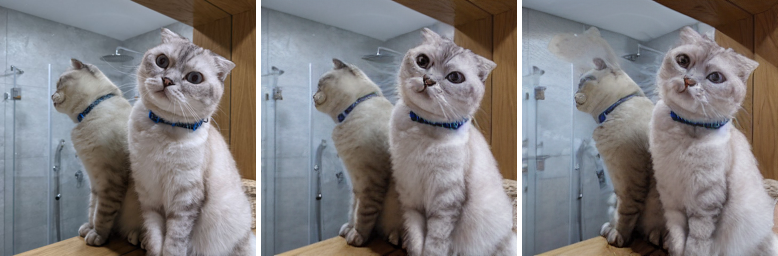

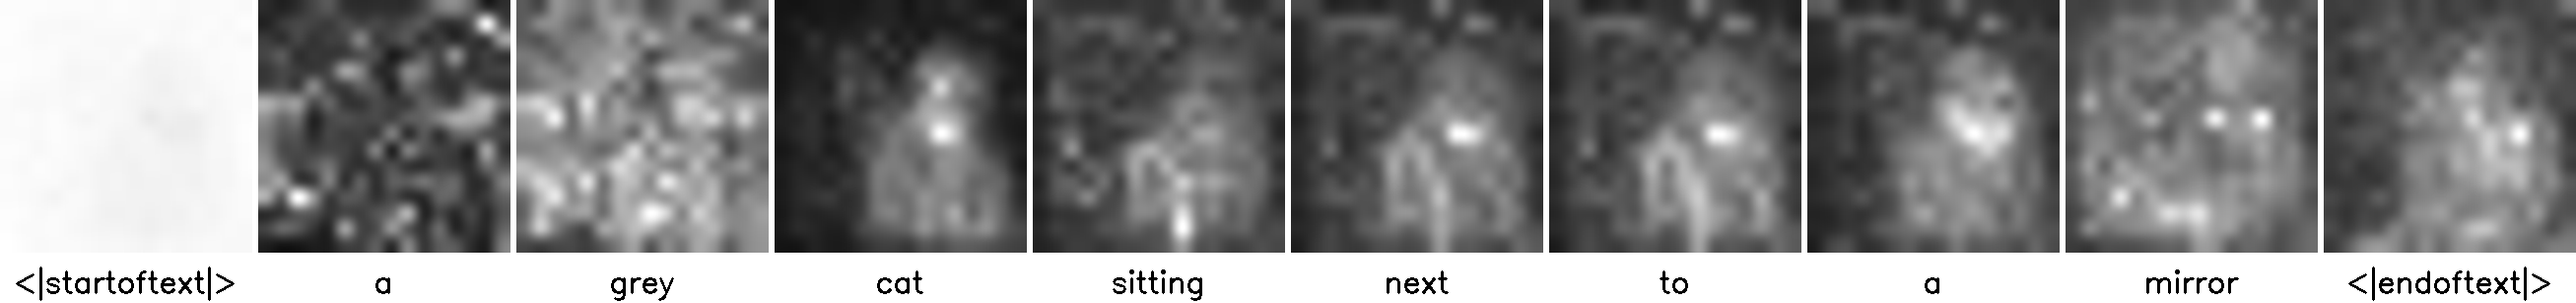

In [9]:
prompts = [prompt]
controller = AttentionStore()
image_inv, x_t = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings, verbose=False)
print("showing from left to right: the ground truth image, the vq-autoencoder reconstruction, the null-text inverted image")
ptp_utils.view_images([image_gt, image_enc, image_inv[0]])
show_cross_attention(controller, 16, ["up", "down"])


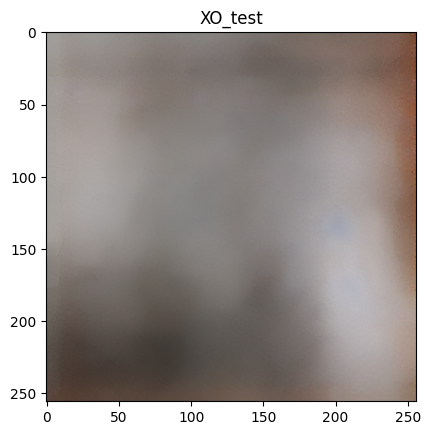

In [10]:
""" Show predicted original samples """

import matplotlib.pyplot as plt

def plot_X0_grid(pred_X0_list):
    num_saved = len(pred_X0_list)
    pred_X0_list, t_list = zip(*pred_X0_list)
    cols = int(torch.sqrt(torch.tensor(num_saved)).item())
    rows = (num_saved + cols - 1) // cols

    h, w, c = pred_X0_list[0].shape
    all_saved_X0s = np.ones((rows * h, cols * w, c), dtype=np.uint8) * 255

    for idx, X0 in enumerate(pred_X0_list):
        row = idx // cols
        col = idx % cols
        all_saved_X0s[row * h:(row + 1) * h, col * w:(col + 1) * w, :] = X0

    fig, ax = plt.subplots()
    ax.imshow(all_saved_X0s)
    ax.axis('off')

    for idx, t in enumerate(t_list):
        row = idx // cols
        col = idx % cols
        y_pos = row * h
        x_pos = col * w + w // 2
        ax.text(x_pos, y_pos - 10, f't={t}', ha='center', va='bottom', fontsize=8, color='black')

pred_X0s = null_inversion.pred_originals
# plot_X0_grid(pred_X0s)
plt.imshow(pred_X0s[4][0]), plt.title('XO_test')
plt.show()